In [1]:
import pyomo.environ as pyo
import pyomo.dae as dae
import matplotlib.pyplot as plt

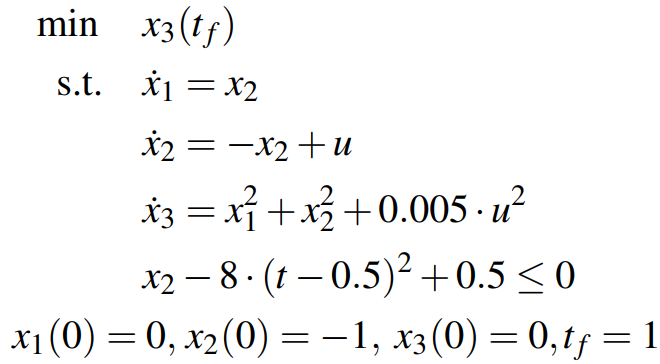

In [2]:
m = pyo.ConcreteModel()

m.tf = pyo.Param(initialize=1)
m.t = dae.ContinuousSet(bounds=(0,m.tf))

In [3]:
m.u = pyo.Var(m.t, initialize=0)
m.x1 = pyo.Var(m.t)
m.x2 = pyo.Var(m.t)
m.x3 = pyo.Var(m.t)
m.dx1 = dae.DerivativeVar(m.x1, wrt=m.t)
m.dx2 = dae.DerivativeVar(m.x2, wrt=m.t)
m.dx3 = dae.DerivativeVar(m.x3, wrt=m.t)

# m.dx1dt2 = dae.DerivativeVar(m.x1, wrt=(m.t, m.t))

In [4]:
def _x1dot(m, t):
    return m.dx1[t] == m.x2[t]
m.x1dotcon = pyo.Constraint(m.t, rule=_x1dot)

def _x2dot(m, t):
    return m.dx2[t] == -m.x2[t] + m.u[t]
m.x2dotcon = pyo.Constraint(m.t, rule=_x2dot)

def _x3dot(m, t):
    return m.dx3[t] == m.x1[t]**2 + m.x2[t]**2 + 0.005*m.u[t]**2
m.x3dotcon = pyo.Constraint(m.t, rule=_x3dot)

In [5]:
m.x1dotcon[m.t.first()].deactivate()
m.x2dotcon[m.t.first()].deactivate()
m.x3dotcon[m.t.first()].deactivate()

m.x1[0].fix(0)
m.x2[m.t.first()].fix(-1)
m.x3[m.t.first()].fix(0)

In [6]:
m.obj = pyo.Objective(expr=m.x3[m.tf])

def _con(m, t):
    return m.x2[t] - 8*(t - 0.5)**2 + 0.5 <= 0
m.con = pyo.Constraint(m.t, rule=_con)

# finite difference transformation

In [ ]:
discretizer = pyo.TransformationFactory("dae.finite_difference")
discretizer.apply_to(m, nfe=50, wrt=m.t, scheme="BACKWARD") # CENTRAL, # FORWARD

The nfe keyword argument stands for “number of finite elements”, and it specifies the number of discretization points that are used in the discretization. The
scheme keyword specifies which finite difference method to apply. 

# Collocation Transformation

In [7]:
discretizer = pyo.TransformationFactory("dae.collocation")
discretizer.apply_to(m,nfe=7,ncp=6,scheme= "LAGRANGE-RADAU") # LAGRANGE-LEGENDRE

The nfe keyword argument specifies the number of finite elements and the ncp
argument specifies the number of collocation points within each finite element

## Restricting Control Input Profiles

One of the main design considerations for the pyomo.dae package was the extensibility of the package to include general implementations of common operations
applied to dynamic optimization problems. **One such common operation in the area
of optimal control is restricting the control input to have a certain profile, typically
piecewise constant or piecewise linear**. Often times when a model is discretized using collocation over finite elements ***the control variable is restricted to be constant
over each finite element***. The pyomo.dae package includes a function for doing
this after a collocation discretization has been applied to a model. It works by reducing the number of free collocation points for a particular variable. For example,
to restrict our control input u to be piecewise constant in our small optimal control problem you would add the following line right after applying a discretization
transformation:

In [8]:
# works with Collocation Transformation

discretizer.reduce_collocation_points(m, var=m.u, ncp=1, contset=m.t)

# solve the model

In [9]:
solver=pyo.SolverFactory("ipopt")
solver.solve(m, tee=True)

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     1438
Number of nonzeros in inequality constraint Jacobian.:       42
Number of nonzeros in Lagrangian Hessian.............:      126

Total number of variables............................:      294
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0


{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 330, 'Number of variables': 294, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.11.1\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.052130937576293945}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [10]:
def plotter(subplot, x, *y, **kwds):
    plt.subplot(subplot)
    for i,_y in enumerate(y):
        plt.plot(list(x), [pyo.value(_y[t]) for t in x], "brgcmk"[i%6])
        if kwds.get("points", False):
            plt.plot(list(x), [pyo.value(_y[t]) for t in x], "o")
    plt.title(kwds.get("title",""))
    plt.legend(tuple(_y.name for _y in y))
    plt.xlabel(x.name)

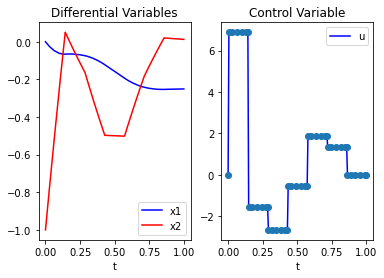

In [11]:
plotter(121, m.t, m.x1, m.x2, title="Differential Variables")
plotter(122, m.t, m.u, title="Control Variable", points=True)
plt.show()